In [1]:
import os
import sys
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [2]:
import s3fs

s3 = s3fs.core.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.cern.ch'})

In [3]:
flist = s3.glob('s3://jec-data/open/katib/train/*.root') + s3.glob('s3://jec-data/open/katib/val/*.root')  + s3.glob('s3://jec-data/open/katib/test/*.root') 

In [4]:
flist

['jec-data/open/katib/train/JetNtuple_RunIISummer16_13TeV_MC_10.root',
 'jec-data/open/katib/train/JetNtuple_RunIISummer16_13TeV_MC_19.root',
 'jec-data/open/katib/train/JetNtuple_RunIISummer16_13TeV_MC_27.root',
 'jec-data/open/katib/train/JetNtuple_RunIISummer16_13TeV_MC_35.root',
 'jec-data/open/katib/train/JetNtuple_RunIISummer16_13TeV_MC_66.root',
 'jec-data/open/katib/train/JetNtuple_RunIISummer16_13TeV_MC_7.root',
 'jec-data/open/katib/val/JetNtuple_RunIISummer16_13TeV_MC_11.root',
 'jec-data/open/katib/val/JetNtuple_RunIISummer16_13TeV_MC_90.root',
 'jec-data/open/katib/test/JetNtuple_RunIISummer16_13TeV_MC_103.root',
 'jec-data/open/katib/test/JetNtuple_RunIISummer16_13TeV_MC_96.root']

In [5]:
branches = [
    'genJetPt', 'jetPt', 'jetEta', 'jetPhi', 'jetMass', 'jetArea', 
    'QG_ptD', 'QG_axis2', 'QG_mult', 
    'PF_pT', 'PF_dR', 'PF_dTheta', 'PF_dPhi', 'PF_dEta'
]

In [6]:
from utils.fileio import read_files

## Count

In [7]:
train = read_files(flist[:6], ['jetPt'], s3)
val = read_files(flist[6:8], ['jetPt'], s3)
test = read_files(flist[8:], ['jetPt'], s3)

In [8]:
n_train = len(train['jetPt'])
n_train

845038

In [9]:
n_val = len(val['jetPt'])
n_val

286401

In [10]:
n_test = len(test['jetPt'])
n_test

286645

In [11]:
tot = n_train + n_val + n_test
tot

1418084

In [12]:
n_train / tot

0.5959012301104871

In [13]:
n_val / tot

0.20196335336975807

In [14]:
n_test / tot

0.20213541651975483

## Feature histograms

In [15]:
data = read_files(flist[:2], branches, s3)

In [16]:
data

{'genJetPt': <Array [123, 69.1, 39.1, 844, ..., 181, 132, 356, 308] type='279347 * float32'>,
 'jetPt': <Array [129, 62.8, 47.4, 847, ..., 207, 142, 322, 318] type='279347 * float32'>,
 'jetEta': <Array [1.96, 0.229, -1.06, ..., 0.613, -0.831, -0.733] type='279347 * float32'>,
 'jetPhi': <Array [-1.39, 1.95, 1.49, ..., 1.28, -0.993, 2.16] type='279347 * float32'>,
 'jetMass': <Array [13.8, 9.04, 8.57, 123, ..., 19.4, 34.4, 30.7] type='279347 * float32'>,
 'jetArea': <Array [0.509, 0.519, 0.509, ..., 0.509, 0.499, 0.469] type='279347 * float32'>,
 'QG_ptD': <Array [0.37, 0.415, 0.35, ..., 0.433, 0.435, 0.363] type='279347 * float32'>,
 'QG_axis2': <Array [0.0283, 0.0391, 0.0373, ..., 0.0166, 0.0142] type='279347 * float32'>,
 'QG_mult': <Array [19, 13, 16, 33, 53, ..., 17, 20, 19, 22, 26] type='279347 * float32'>,
 'PF_pT': <Array [[1.71, 5.91, ..., 0.314, 1.25], ...] type='279347 * var * float32'>,
 'PF_dR': <Array [[0.185, 0.102, ..., 0.814, 0.91], ...] type='279347 * var * float32'>,

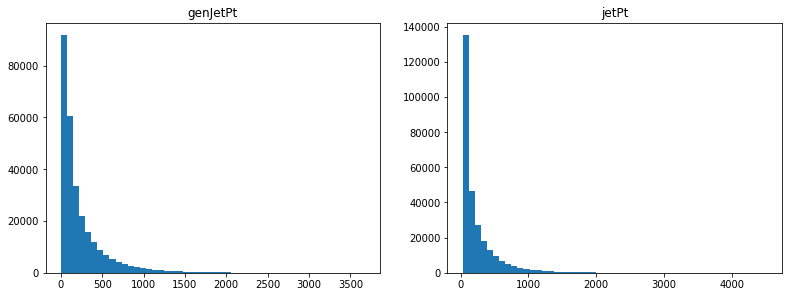

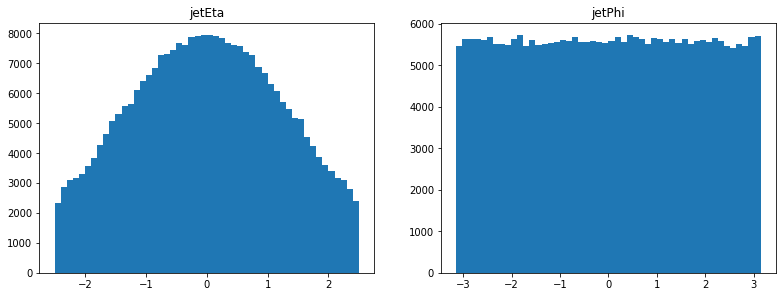

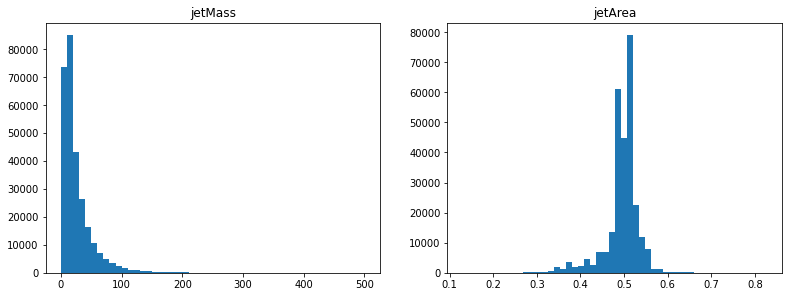

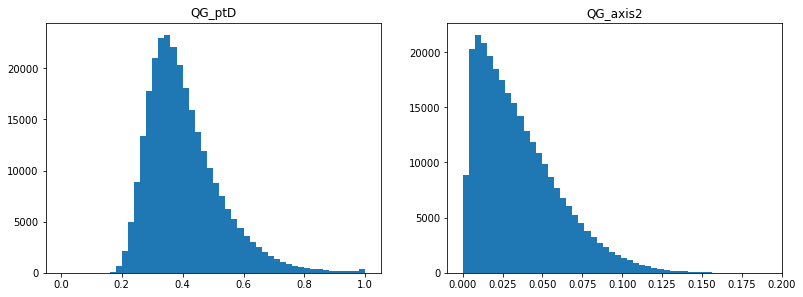

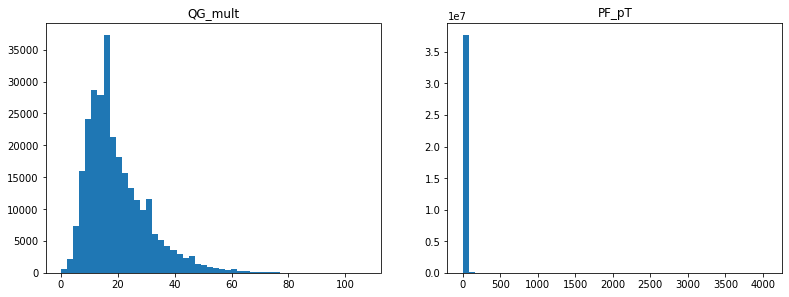

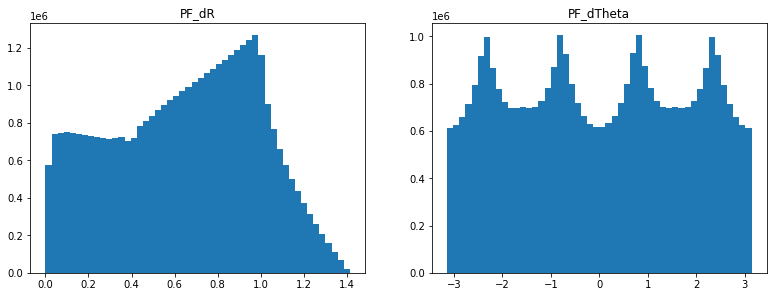

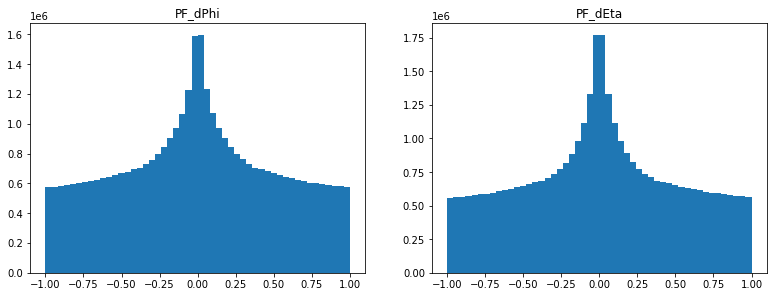

In [17]:
iter_branches = iter(branches)
plot_two = True
for branch in iter_branches:
    try:
        branch1, branch2 = branch, next(iter_branches)
    except:
        plot_two = False

    if plot_two:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.2, 4.6))
        ax1.hist(ak.flatten(data[branch1], axis=-1), bins=50)
        ax1.set_title(branch1)
        ax2.hist(ak.flatten(data[branch2], axis=-1), bins=50)
        ax2.set_title(branch2)
        plt.show()
    else:
        plt.hist(ak.flatten(data[branch], axis=-1), bins=50)
        plt.title(branch)
        plt.show()

In [18]:
jets = read_files(flist, ['jetPt', 'genJetPt', 'genJetEta'], s3)

In [19]:
df = ak.to_dataframe(jets)
df.columns = ['pt', 'pt_gen', 'eta_gen']
df.head()

,pt,pt_gen,eta_gen
entry,,,
0,129.443253,123.299393,1.954787
1,62.821434,69.085747,0.232803
2,47.355648,39.102703,-1.028388
3,847.222656,843.886658,0.409617
4,839.086914,829.503967,0.863384


In [20]:
outdir = 'figs/data'

for ext in ['png', 'pdf', 'svg']:
    os.makedirs(os.path.join(outdir, ext), exist_ok=True)

## Data binned by eta and pT

In [21]:
# del sys.modules[plot_spectrum.__module__]

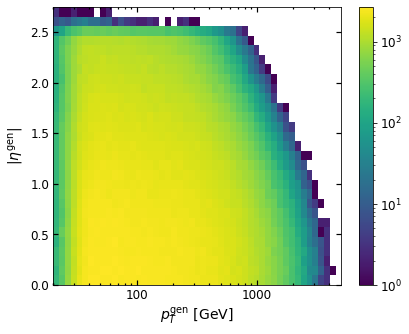

In [22]:
from utils.visualize_data import plot_spectrum

plot_spectrum(df, outdir)

## Target

In [23]:
filtered = df[(df.pt_gen > 20) & (np.abs(df.eta_gen) < 2.5)]

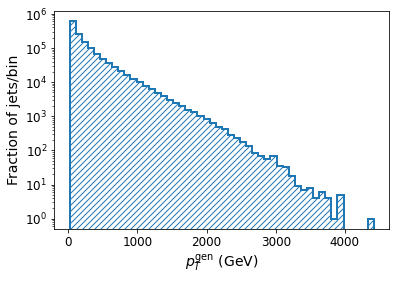

In [24]:
plt.hist(filtered.pt_gen, bins=50, histtype='stepfilled', linewidth=2, facecolor='white', hatch='////', edgecolor='tab:blue')
plt.xlabel('$p_T^\mathrm{gen}$ (GeV)')
plt.ylabel('Fraction of jets/bin')
plt.yscale('log')
plt.show()

$p_T^\mathrm{gen}$ has a very wide distribution so the following is used as target instead:

In [25]:
# del sys.modules[plot_target.__module__]

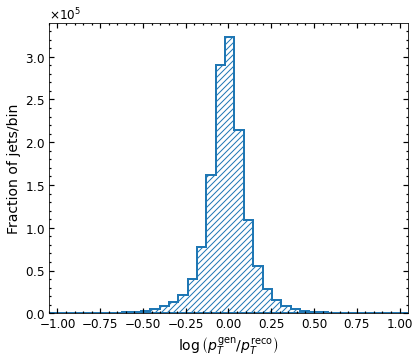

In [26]:
from utils.visualize_data import plot_target

plot_target(filtered, outdir)